In [1]:
import sys
import torch
from torch import nn

import math
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(111)

# Create and visualize training data

In [3]:
# prepare training data
train_data_len = 1024
train_data = torch.zeros(train_data_len,2) # initialize tensors
train_data[:,0] = 2 * math.pi * torch.rand(train_data_len) # store random values in the interval [0,2*pi]
train_data[:,1] = torch.sin(train_data[:, 0]) # sin of first tensor
train_labels = torch.zeros(train_data_len)
train_set = [(train_data[i], train_labels[i]) for i in range(train_data_len)]

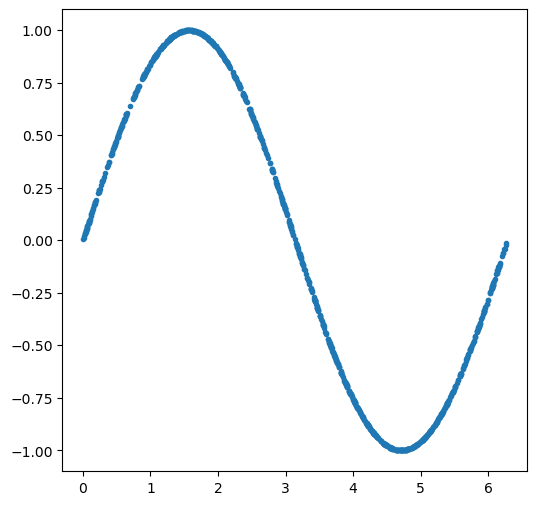

In [4]:
# examine the training data

fig, ax = plt.subplots(1,1,figsize=(6,6))

ax.plot(train_data[:, 0], train_data[:, 1], ".")

In [5]:
# create a pytorch data loader
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

# Define discriminator and generator models

In [6]:
# implement discriminator: a model that receives samples from real data or from the generator
# and provides probability that it belongs to the real training data

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(nn.Linear(2, 256), #2-dimensional input, first hidden layer has 256 neurons
                                    nn.ReLU(), # all hidden layers have ReLU activation function
                                    nn.Dropout(0.3), # dropout layers after each hidden layer to avoid overfitting
                                    nn.Linear(256, 128), # second hidden layer, 128 neurons
                                    nn.ReLU(),
                                    nn.Dropout(0.3),
                                    nn.Linear(128, 64), # third hidden layer, 64 neurons
                                    nn.ReLU(),
                                    nn.Dropout(0.3),
                                    nn.Linear(64, 1),
                                    nn.Sigmoid(),
                                    )
    def forward(self, x):
        output = self.model(x)
        return output

In [7]:
# implement generator: a model that takes samples as input and generates data resemling the data in the training set

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(nn.Linear(2, 16), #2-dimensional input, first hidden layer has 256 neurons
                                    nn.ReLU(), # all hidden layers have ReLU activation function
                                    nn.Linear(16, 32), # second hidden layer, 128 neurons
                                    nn.ReLU(),
                                    nn.Linear(32, 2)
                                  )
        
    def forward(self, x):
        output = self.model(x)
        return output

# Training the models

In [8]:
# initialize empty models
discriminator = Discriminator()
generator = Generator()

In [9]:
# define model parameters
lr = 0.001
num_epochs = 300
loss_function = nn.BCELoss() # binary cross-entropy loss

In [10]:
# define optimizers for each model
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [11]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        
        # data for training the discriminator
        real_samples_labels = torch.ones((batch_size,1))
        latent_space_samples = torch.randn((batch_size, 2))
        
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size,1))
        
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))
        
        # train discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()
        
        # data for training the generator
        latent_space_samples = torch.randn((batch_size, 2))
        
        generator.zero_grad() 
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()
        
        # show loss
        if (epoch % 10 == 0) and (n == batch_size - 1):
            print(f"Epoch: {epoch} Loss Discriminator: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss Generator: {loss_generator}\n")

Epoch: 0 Loss Discriminator: 0.19106775522232056
Epoch: 0 Loss Generator: 1.8886789083480835
Epoch: 10 Loss Discriminator: 0.6589420437812805
Epoch: 10 Loss Generator: 0.9346314072608948
Epoch: 20 Loss Discriminator: 0.6484917402267456
Epoch: 20 Loss Generator: 0.9305144548416138
Epoch: 30 Loss Discriminator: 0.6232972741127014
Epoch: 30 Loss Generator: 0.8461633920669556
Epoch: 40 Loss Discriminator: 0.6152937412261963
Epoch: 40 Loss Generator: 0.7221050262451172
Epoch: 50 Loss Discriminator: 0.6340388655662537
Epoch: 50 Loss Generator: 0.8965965509414673
Epoch: 60 Loss Discriminator: 0.6844289898872375
Epoch: 60 Loss Generator: 0.7352980971336365
Epoch: 70 Loss Discriminator: 0.6809797286987305
Epoch: 70 Loss Generator: 0.6965097188949585
Epoch: 80 Loss Discriminator: 0.6557415723800659
Epoch: 80 Loss Generator: 0.7019643783569336
Epoch: 90 Loss Discriminator: 0.6967378258705139
Epoch: 90 Loss Generator: 0.7134181261062622
Epoch: 100 Loss Discriminator: 0.6520562767982483
Epoch: 100 

# Visualize generated samples

In [12]:
latent_space_samples = torch.randn(100,2)
generated_samples = generator(latent_space_samples)

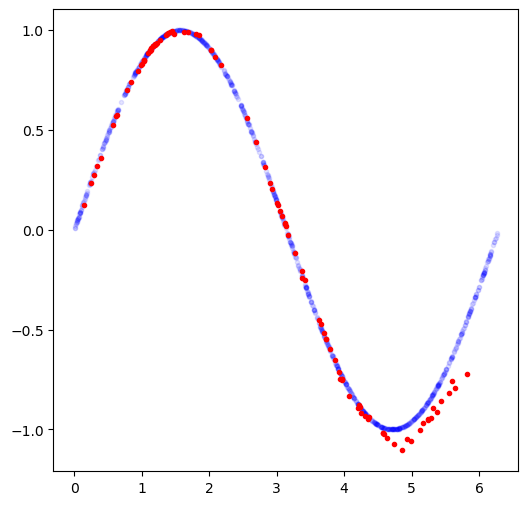

In [16]:
generated_samples = generated_samples.detach() # detach tensor from pytorch computational graph

fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.plot(train_data[:, 0], train_data[:, 1], ".", alpha=0.1, color="blue") # original data
ax.plot(generated_samples[:, 0], generated_samples[:, 1], ".", color="red") # generated data